In [1]:
%pip install transformers datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 82.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 78.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 20.0 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/martingrzzler/robanohashi-thesis-notebook.git

Cloning into 'robanohashi-thesis-notebook'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 34 (delta 12), reused 29 (delta 7), pack-reused 0
Unpacking objects: 100% (34/34), 183.50 KiB | 6.33 MiB/s, done.


In [3]:
%cd robanohashi-thesis-notebook

/content/robanohashi-thesis-notebook


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("martingrzzler/bert-word-conreteness")

In [6]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [7]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/mnemonics_benchmark')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [65]:
ds

DatasetDict({
    train: Dataset({
        features: ['kanji_id', 'component_meanings', 'wanikani_mnemonic', 'kanji_meaning', 'gpt2xl_mnemonic', 'gpt3_paragraph', 'gpt3_mnemonic'],
        num_rows: 190
    })
})

In [48]:
sample = ds['train'][0]
print(sample['gpt3_paragraph'])

A woman was using a catapult for recreation in her backyard. She was having a blast launching objects into the air and watching them fly. She was enjoying the peacefulness of the moment and the satisfaction of her successful shots.


In [67]:
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords

sw = set(stopwords.words('english'))

def tokenize(text, menmonic_words = set()):
    text = re.sub('<.*?>', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [w for w in tokens if not w in sw and not w in menmonic_words]
    filtered_tokens = [w for w in filtered_tokens if w.isalpha()]

    return filtered_tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
from lib.model import bert_predict_word

def concreteness_mean(text, mnemonic_words = set()):
    tokens = tokenize(text, mnemonic_words)
    scores = [bert_predict_word(token, tokenizer, model, device) for token in tokens]
    return sum(scores) / len(scores)

In [76]:
def map_concreteness_mean(bar=None):
    def func(example):
        mnemonic_words = set(example['component_meanings'] + example['kanji_meaning'])
        example['gpt3_paragraph_concreteness'] = concreteness_mean(example['gpt3_paragraph'], mnemonic_words)
        example['gpt3_mnemonic_concreteness'] = concreteness_mean(example['gpt3_mnemonic'], mnemonic_words)
        example['wanikani_concreteness'] = concreteness_mean(example['wanikani_mnemonic'], mnemonic_words)
        example['gpt2xl_concreteness'] = concreteness_mean(example['gpt2xl_mnemonic'], mnemonic_words)
        if bar is not None:
            bar.update(1)
        return example
    return func

In [77]:
map_concreteness_mean()(sample)

{'kanji_id': 1885,
 'component_meanings': 'woman,catapult',
 'wanikani_mnemonic': "A <radical>woman</radical> loves her <radical>catapult</radical> for some good ol' fashioned <kanji>recreation</kanji>. You ask the woman what she does for fun... for recreation. She says, she goes out and shoots her catapult.",
 'kanji_meaning': 'recreation',
 'gpt2xl_mnemonic': "This is a rush transcript. Copy may not be in its final form, recreation of woman being catapulted to her death has been edited out.)\n\n\nAMY GOODMAN: We begin today's show with the shocking news that two women have died after jumping from an overpass near Los Angeles International Airport and landing on I-5 southbound just before",
 'gpt3_paragraph': 'A woman was using a catapult for recreation in her backyard. She was having a blast launching objects into the air and watching them fly. She was enjoying the peacefulness of the moment and the satisfaction of her successful shots.',
 'gpt3_mnemonic': "Once upon a time there was

In [78]:
import tqdm.auto as tqdm

bar = tqdm.tqdm(range(len(ds['train'])))

ds_concreteness = ds.map(map_concreteness_mean(bar))

  0%|          | 0/190 [00:00<?, ?it/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [79]:
ds_concreteness['train'][100]

{'kanji_id': 1020,
 'component_meanings': 'canopy,clan,ground',
 'wanikani_mnemonic': 'Under a <radical>canopy</radical> your <radical>clan</radical> digs in the <radical>ground</radical>, trying to get to the <kanji>bottom</kanji>. They want to build a nice home your entire clan can live in, but they need to get to the bottom before they\'ll start building. Picture all of the people in your clan under this canopy digging with all their might, trying to find the bottom. "Isn\'t there... no bottom though?" you think to yourself.',
 'kanji_meaning': 'bottom',
 'gpt2xl_mnemonic': "This is a rush transcript. Copy may not be in its final form ground bottom, but it's good enough for clan news and canopy-climbing fun!\n\n\nNERMEEN SHAIKH: We turn now to look at one of the most controversial issues that has come up during this presidential campaign—the role played by Wall Street",
 'gpt3_paragraph': "The canopy of the trees in the clan's forest provided a shelter from the sun, and the ground b

In [80]:
# import f test
from scipy.stats import f_oneway


f, p = f_oneway( ds_concreteness['train']['gpt3_paragraph_concreteness'], ds_concreteness['train']['gpt3_mnemonic_concreteness'], ds_concreteness['train']['wanikani_concreteness'], ds_concreteness['train']['gpt2xl_concreteness'])

In [81]:
print(f"p-value: {p}")

p-value: 0.16634730587195296


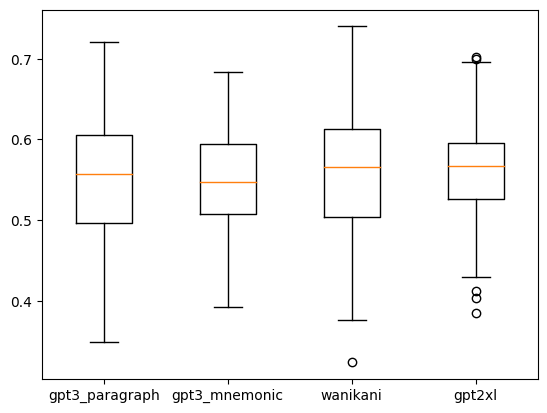

In [82]:
# pairwise tukey test
from scipy.stats import tukey_hsd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
ax.boxplot([ds_concreteness['train']['gpt3_paragraph_concreteness'], ds_concreteness['train']['gpt3_mnemonic_concreteness'], ds_concreteness['train']['wanikani_concreteness'], ds_concreteness['train']['gpt2xl_concreteness']])
ax.set_xticklabels(['gpt3_paragraph', 'gpt3_mnemonic', 'wanikani', 'gpt2xl'])
plt.show()

In [109]:
def concreteness_ngram_max(text, mnemonic_words = set(), n=3):
    tokens = tokenize(text, mnemonic_words)
    scores = [bert_predict_word(token, tokenizer, model, device) for token in tokens]
    sorted_scores = sorted(scores, reverse=True)
    print(sorted_scores)

    return sum(sorted_scores[:n]) / n

In [85]:
def map_concreteness_ngram_max(n, bar=None):
    def func(example):
        mnemonic_words = set(example['component_meanings'] + example['kanji_meaning'])
        example['gpt3_paragraph_concreteness'] = concreteness_ngram_max(example['gpt3_paragraph'], mnemonic_words, n)
        example['gpt3_mnemonic_concreteness'] = concreteness_ngram_max(example['gpt3_mnemonic'], mnemonic_words, n)
        example['wanikani_concreteness'] = concreteness_ngram_max(example['wanikani_mnemonic'], mnemonic_words, n)
        example['gpt2xl_concreteness'] = concreteness_ngram_max(example['gpt2xl_mnemonic'], mnemonic_words, n)
        if bar is not None:
            bar.update(1)
        return example
    return func

In [86]:
map_concreteness_ngram_max(3)(sample)

{'kanji_id': 1885,
 'component_meanings': 'woman,catapult',
 'wanikani_mnemonic': "A <radical>woman</radical> loves her <radical>catapult</radical> for some good ol' fashioned <kanji>recreation</kanji>. You ask the woman what she does for fun... for recreation. She says, she goes out and shoots her catapult.",
 'kanji_meaning': 'recreation',
 'gpt2xl_mnemonic': "This is a rush transcript. Copy may not be in its final form, recreation of woman being catapulted to her death has been edited out.)\n\n\nAMY GOODMAN: We begin today's show with the shocking news that two women have died after jumping from an overpass near Los Angeles International Airport and landing on I-5 southbound just before",
 'gpt3_paragraph': 'A woman was using a catapult for recreation in her backyard. She was having a blast launching objects into the air and watching them fly. She was enjoying the peacefulness of the moment and the satisfaction of her successful shots.',
 'gpt3_mnemonic': "Once upon a time there was

In [87]:
bar = tqdm.tqdm(range(len(ds['train'])))

ds_concreteness_ngram_max = ds.map(map_concreteness_ngram_max(3, bar))

  0%|          | 0/190 [00:00<?, ?it/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [88]:
f, p = f_oneway( ds_concreteness_ngram_max['train']['gpt3_paragraph_concreteness'], ds_concreteness_ngram_max['train']['gpt3_mnemonic_concreteness'], ds_concreteness_ngram_max['train']['wanikani_concreteness'], ds_concreteness_ngram_max['train']['gpt2xl_concreteness'])
print(f"p-value: {p}")

p-value: 2.8836884741710876e-07


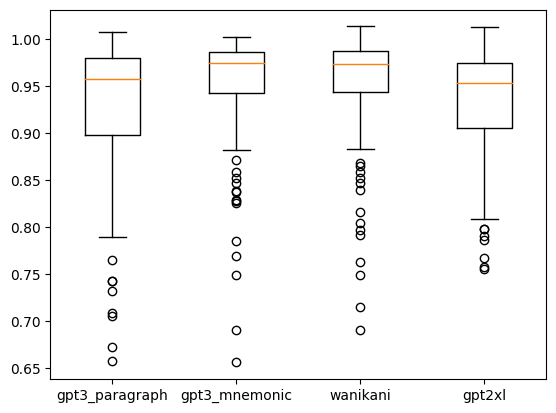

In [89]:
fig, ax = plt.subplots(1,1)

ax.boxplot([ds_concreteness_ngram_max['train']['gpt3_paragraph_concreteness'], ds_concreteness_ngram_max['train']['gpt3_mnemonic_concreteness'], ds_concreteness_ngram_max['train']['wanikani_concreteness'], ds_concreteness_ngram_max['train']['gpt2xl_concreteness']])
ax.set_xticklabels(['gpt3_paragraph', 'gpt3_mnemonic', 'wanikani', 'gpt2xl'])
plt.show()

In [90]:
from scipy.stats import tukey_hsd

res = tukey_hsd(ds_concreteness_ngram_max['train']['gpt3_paragraph_concreteness'], ds_concreteness_ngram_max['train']['gpt3_mnemonic_concreteness'], ds_concreteness_ngram_max['train']['wanikani_concreteness'], ds_concreteness_ngram_max['train']['gpt2xl_concreteness'])
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.026     0.000    -0.041    -0.011
 (0 - 2)     -0.027     0.000    -0.043    -0.012
 (0 - 3)     -0.005     0.833    -0.020     0.010
 (1 - 0)      0.026     0.000     0.011     0.041
 (1 - 2)     -0.002     0.992    -0.017     0.014
 (1 - 3)      0.021     0.003     0.006     0.036
 (2 - 0)      0.027     0.000     0.012     0.043
 (2 - 1)      0.002     0.992    -0.014     0.017
 (2 - 3)      0.022     0.001     0.007     0.038
 (3 - 0)      0.005     0.833    -0.010     0.020
 (3 - 1)     -0.021     0.003    -0.036    -0.006
 (3 - 2)     -0.022     0.001    -0.038    -0.007



In [91]:
bar = tqdm.tqdm(range(len(ds['train'])))
concreteness_10_gram_max = ds.map(map_concreteness_ngram_max(10, bar))

  0%|          | 0/190 [00:00<?, ?it/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [92]:
f, p = f_oneway( concreteness_10_gram_max['train']['gpt3_paragraph_concreteness'], concreteness_10_gram_max['train']['gpt3_mnemonic_concreteness'], concreteness_10_gram_max['train']['wanikani_concreteness'], concreteness_10_gram_max['train']['gpt2xl_concreteness'])
print(f"p-value: {p}")

p-value: 7.481534970379495e-27


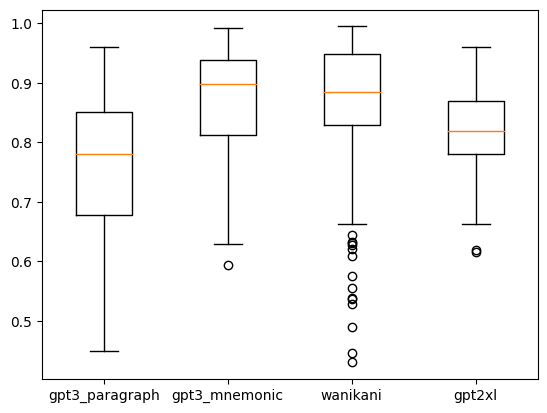

In [93]:
fig, ax = plt.subplots(1,1)

ax.boxplot([concreteness_10_gram_max['train']['gpt3_paragraph_concreteness'], concreteness_10_gram_max['train']['gpt3_mnemonic_concreteness'], concreteness_10_gram_max['train']['wanikani_concreteness'], concreteness_10_gram_max['train']['gpt2xl_concreteness']])
ax.set_xticklabels(['gpt3_paragraph', 'gpt3_mnemonic', 'wanikani', 'gpt2xl'])
plt.show()

In [94]:

from scipy.stats import tukey_hsd

res = tukey_hsd(concreteness_10_gram_max['train']['gpt3_paragraph_concreteness'], concreteness_10_gram_max['train']['gpt3_mnemonic_concreteness'], concreteness_10_gram_max['train']['wanikani_concreteness'], concreteness_10_gram_max['train']['gpt2xl_concreteness'])
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.107     0.000    -0.134    -0.081
 (0 - 2)     -0.099     0.000    -0.126    -0.073
 (0 - 3)     -0.058     0.000    -0.084    -0.031
 (1 - 0)      0.107     0.000     0.081     0.134
 (1 - 2)      0.008     0.857    -0.018     0.035
 (1 - 3)      0.050     0.000     0.023     0.076
 (2 - 0)      0.099     0.000     0.073     0.126
 (2 - 1)     -0.008     0.857    -0.035     0.018
 (2 - 3)      0.041     0.000     0.015     0.068
 (3 - 0)      0.058     0.000     0.031     0.084
 (3 - 1)     -0.050     0.000    -0.076    -0.023
 (3 - 2)     -0.041     0.000    -0.068    -0.015



In [95]:
ngram_r = [3, 5, 10, 15, 20, 25, 30, 35]

p_values = []
bar = tqdm.tqdm(range(len(ds['train']) * len(ngram_r)))

for n in ngram_r:
    concreteness_n_gram_max = ds.map(map_concreteness_ngram_max(n, bar))
    f, p = f_oneway( concreteness_n_gram_max['train']['gpt3_paragraph_concreteness'], concreteness_n_gram_max['train']['gpt3_mnemonic_concreteness'], concreteness_n_gram_max['train']['wanikani_concreteness'], concreteness_n_gram_max['train']['gpt2xl_concreteness'])
    p_values.append(p)

  0%|          | 0/1520 [00:00<?, ?it/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

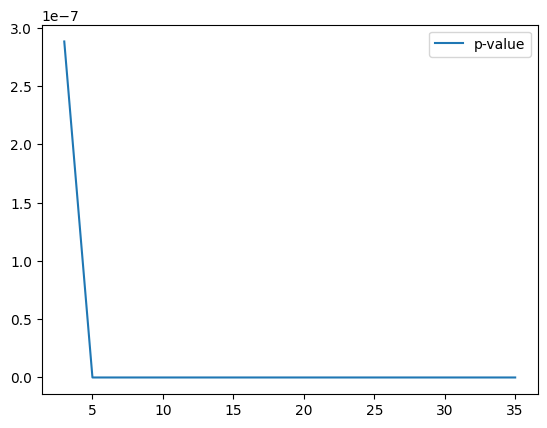

In [96]:
plt.plot(ngram_r, p_values)
plt.legend(['p-value'])
plt.show()

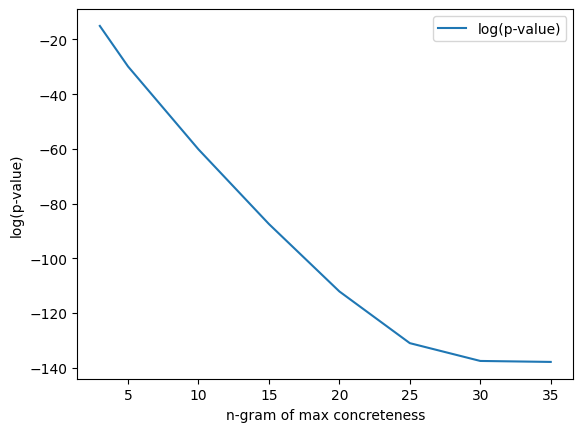

In [103]:
import numpy as np
plt.plot(ngram_r, np.log(p_values))
plt.legend(['log(p-value)'])
plt.xlabel('n-gram of max concreteness')
plt.ylabel('log(p-value)')
plt.show()

In [104]:
bar = tqdm.tqdm(range(len(ds['train'])))

ds_concreteness_30 = ds.map(map_concreteness_ngram_max(30, bar))

  0%|          | 0/190 [00:00<?, ?it/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

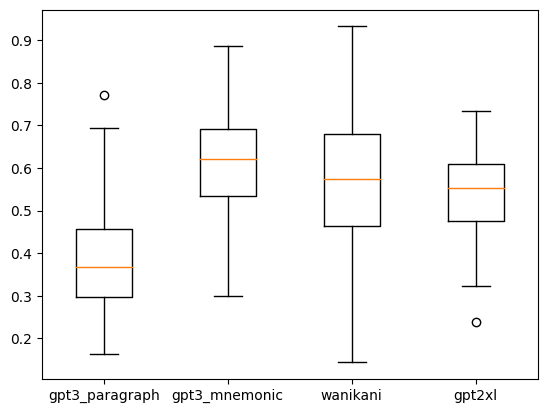

In [105]:
f, p = f_oneway( ds_concreteness_30['train']['gpt3_paragraph_concreteness'], ds_concreteness_30['train']['gpt3_mnemonic_concreteness'], ds_concreteness_30['train']['wanikani_concreteness'], ds_concreteness_30['train']['gpt2xl_concreteness'])

fig, ax = plt.subplots(1,1)

ax.boxplot([ds_concreteness_30['train']['gpt3_paragraph_concreteness'], ds_concreteness_30['train']['gpt3_mnemonic_concreteness'], ds_concreteness_30['train']['wanikani_concreteness'], ds_concreteness_30['train']['gpt2xl_concreteness']])
ax.set_xticklabels(['gpt3_paragraph', 'gpt3_mnemonic', 'wanikani', 'gpt2xl'])
plt.show()

In [106]:
res = tukey_hsd(ds_concreteness_30['train']['gpt3_paragraph_concreteness'], ds_concreteness_30['train']['gpt3_mnemonic_concreteness'], ds_concreteness_30['train']['wanikani_concreteness'], ds_concreteness_30['train']['gpt2xl_concreteness'])
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.226     0.000    -0.260    -0.193
 (0 - 2)     -0.177     0.000    -0.210    -0.143
 (0 - 3)     -0.161     0.000    -0.194    -0.127
 (1 - 0)      0.226     0.000     0.193     0.260
 (1 - 2)      0.050     0.001     0.016     0.083
 (1 - 3)      0.066     0.000     0.032     0.099
 (2 - 0)      0.177     0.000     0.143     0.210
 (2 - 1)     -0.050     0.001    -0.083    -0.016
 (2 - 3)      0.016     0.613    -0.018     0.050
 (3 - 0)      0.161     0.000     0.127     0.194
 (3 - 1)     -0.066     0.000    -0.099    -0.032
 (3 - 2)     -0.016     0.613    -0.050     0.018



### Conclusion

The reason gpt2 may also be rated fairly high could be because it spits out anything that doesn't have to be super coherent while gpt in the paragraph case makes the difference very obvious. The differnce for the mean of the paragrah is explained by the fact that the average token length is only 20 so dividing by 30 unfairly punishes the text, so 30 as a value should not be used. 10 on the other hand is a pretty good value.

Good results by for $$x = {x_1,X_2,...x_n}$$ x being tokens from a mnemonic

$$score(x)=sort(concreteness(x))/10$$